In [29]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('eth_open.csv')
print(df)

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [31]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_close.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,119.715439,116.157440,117.110756,117.157852,2421720343,117.157852,3.557999,121.718783,127.202195,135.541803,2.622529,15.117100
21,21,2019-01-22,119.664345,114.676682,118.713814,118.747551,2552507405,118.747551,4.987663,121.276579,124.927847,134.455817,2.855369,15.480982
22,22,2019-01-23,119.422798,116.376648,117.462784,117.452606,2556952198,117.452606,3.046150,120.403613,122.543509,132.658995,2.967977,15.139389
23,23,2019-01-24,118.032104,116.006798,117.594955,117.362885,2520843420,117.362885,2.025307,119.537942,121.813580,131.167665,2.736387,15.000088
24,24,2019-01-25,117.802994,115.830154,116.373528,116.378342,2606881898,116.378342,1.972839,118.789242,121.016826,129.359861,2.790005,14.341288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,1661.091309,1583.147827,1608.658325,1608.373169,8909129423,1608.373169,77.943481,1662.544015,1626.081979,1622.118815,32.378460,64.990272
1516,1516,2023-02-25,1608.865112,1567.631714,1594.761108,1594.914917,5657686235,1594.914917,41.233398,1648.698434,1630.009487,1618.670939,38.065500,64.398841
1517,1517,2023-02-26,1645.273438,1590.393066,1640.763672,1640.817139,5727967432,1640.817139,54.880371,1642.759382,1638.998535,1619.105149,35.067535,64.521318
1518,1518,2023-02-27,1662.575684,1615.387939,1634.502441,1634.326416,7239824677,1634.326416,47.187744,1633.002895,1648.106419,1619.985758,23.005899,64.603103


In [32]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

300
(1193, 7, 9) (1193, 1) (300, 7, 9) (300, 1)


In [33]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 49s 32ms/step - loss: 0.0176
Epoch 2/120
40/40 [==============================] - 1s 29ms/step - loss: 0.0049
Epoch 3/120
40/40 [==============================] - 1s 28ms/step - loss: 0.0044
Epoch 4/120
40/40 [==============================] - 1s 33ms/step - loss: 0.0039
Epoch 5/120
40/40 [==============================] - 1s 34ms/step - loss: 0.0033
Epoch 6/120
40/40 [==============================] - 1s 30ms/step - loss: 0.0040
Epoch 7/120
40/40 [==============================] - 1s 29ms/step - loss: 0.0035
Epoch 8/120
40/40 [==============================] - 1s 27ms/step - loss: 0.0031
Epoch 9/120
40/40 [==============================] - 1s 30ms/step - loss: 0.0035
Epoch 10/120
40/40 [==============================] - 1s 32ms/step - loss: 0.0027
Epoch 11/120
40/40 [==============================] - 1s 30ms/step - loss: 0.0032
Epoch 12/120
40/40 [==============================] - 1s 32ms/step - loss: 0.0026
Epoch 13/120
40/40 [====

In [34]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

38/38 [==============================] - 8s 6ms/step
      predict_price  y_train_price  error_price
0        142.047195     106.721954    35.325241
1        136.094040     105.407204    30.686836
2        129.828445     108.900772    20.927673
3        127.847237     107.147682    20.699554
4        128.109406     107.466415    20.642990
...             ...            ...          ...
1188    2867.312744    2729.994141   137.318604
1189    2789.503174    2827.614014   -38.110840
1190    2807.034424    2857.152344   -50.117920
1191    2843.683350    2783.131104    60.552246
1192    2817.056641    2940.226562  -123.169922

[1193 rows x 3 columns]


In [35]:
import pickle
from sklearn.linear_model import ElasticNet

elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [36]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_open.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [37]:
predict_price = model.predict(x_test)
print(predict_price)

10/10 [==============================] - 0s 7ms/step
[[0.591041  ]
 [0.5793162 ]
 [0.55935323]
 [0.5457177 ]
 [0.52726185]
 [0.4859326 ]
 [0.4776562 ]
 [0.45357174]
 [0.41873363]
 [0.42388415]
 [0.43451852]
 [0.45271558]
 [0.44169402]
 [0.44374865]
 [0.42188698]
 [0.4175889 ]
 [0.41517115]
 [0.41378275]
 [0.4230359 ]
 [0.4189584 ]
 [0.41056812]
 [0.4030138 ]
 [0.37690008]
 [0.34933877]
 [0.34285522]
 [0.35279012]
 [0.38140577]
 [0.386316  ]
 [0.37245208]
 [0.36235696]
 [0.35796255]
 [0.3598426 ]
 [0.3622585 ]
 [0.37322557]
 [0.36967763]
 [0.36356783]
 [0.36248243]
 [0.34635174]
 [0.31835854]
 [0.29441944]
 [0.26080275]
 [0.24332756]
 [0.24711035]
 [0.24551316]
 [0.24455333]
 [0.23721981]
 [0.2524184 ]
 [0.25764707]
 [0.26024455]
 [0.2508541 ]
 [0.25309876]
 [0.26509237]
 [0.26804966]
 [0.26265863]
 [0.25473928]
 [0.24452206]
 [0.23085192]
 [0.21434125]
 [0.20529613]
 [0.20183723]
 [0.20232743]
 [0.21402949]
 [0.21903378]
 [0.22511439]
 [0.23388293]
 [0.23863323]
 [0.23845655]
 [0.23400

In [38]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[2889.534 ]
 [2834.3638]
 [2740.4294]
 [2676.2686]
 [2589.4258]
 [2394.9539]
 [2356.01  ]
 [2242.6826]
 [2078.7544]
 [2102.9897]
 [2153.029 ]
 [2238.6538]
 [2186.7927]
 [2196.4607]
 [2093.5923]
 [2073.368 ]
 [2061.9915]
 [2055.4583]
 [2098.9983]
 [2079.812 ]
 [2040.3322]
 [2004.7859]
 [1881.9097]
 [1752.2219]
 [1721.7141]
 [1768.462 ]
 [1903.1108]
 [1926.2156]
 [1860.98  ]
 [1813.4781]
 [1792.8005]
 [1801.647 ]
 [1813.0148]
 [1864.6195]
 [1847.925 ]
 [1819.1758]
 [1814.0685]
 [1738.1667]
 [1606.4468]
 [1493.8031]
 [1335.6222]
 [1253.394 ]
 [1271.1936]
 [1263.6781]
 [1259.1617]
 [1224.6544]
 [1296.1703]
 [1320.7734]
 [1332.9957]
 [1288.8097]
 [1299.3717]
 [1355.8068]
 [1369.722 ]
 [1344.355 ]
 [1307.0911]
 [1259.0146]
 [1194.6908]
 [1117.0011]
 [1074.4398]
 [1058.1643]
 [1060.4708]
 [1115.534 ]
 [1139.0814]
 [1167.6932]
 [1208.953 ]
 [1231.3052]
 [1230.4739]
 [1209.5227]
 [1146.391 ]
 [1069.5857]
 [1070.8822]
 [1141.9208]
 [1218.2645]
 [1309.076 ]
 [1340.863 ]
 [1482.8635]
 [1555.5507]

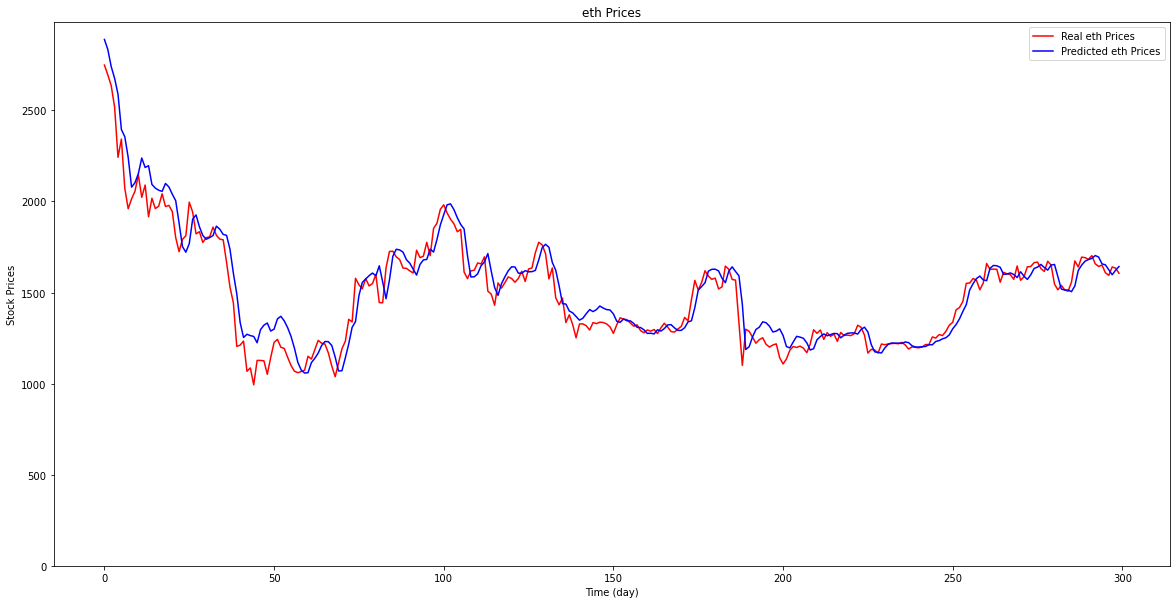

In [39]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real eth Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted eth Prices")
plt.title(f"eth Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [40]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 67.80
MAPE: 4.67%
MSE: 8887.31
RMSE: 94.27
R2: 0.90


In [41]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [42]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))